In [ ]:
# You can get more datasets here https://repository.cloudlab.zhaw.ch/artifactory/deepscores/archives/2017/

!wget https://grfia.dlsi.ua.es/primus/packages/CameraPrIMuS.tgz
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/vocabulary_semantic.txt
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/train.txt
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/test.txt

In [ ]:
!tar -xvf CameraPrIMuS.tgz 
#!tar -xvf primusCalvoRizoAppliedSciences2018.tgz 

In [2]:
import torch, torchvision, PIL, numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import pandas as pd
import pdb
import numpy as np
import cv2
import random
import crnn 
from tqdm.auto import tqdm
import pdb

In [3]:
class MusicClassificationObject:

  def __init__(self, dataset_dir, dataset_filenames, dictionary_path, transform=None, label_transform=None, distortions=False):
        self.distortions = distortions
        self.dataset_dir = dataset_dir
        self.transform = transform 
        self.label_transform = label_transform

        dataset_filenames = open(dataset_filenames,'r')
        dataset_list = dataset_filenames.read().splitlines()
        dataset_filenames.close()

        self.current_idx = 0
        # Dictionary
        self.symbol2index = {}
        self.index2symbol = {}
            
        dict_file = open(dictionary_path,'r')
        dict_list = dict_file.read().splitlines()
        word_idx = 0
        for word in dict_list:
          self.symbol2index[word] = word_idx
          self.index2symbol[word_idx] = word
          word_idx += 1 

        dict_file.close()

        self.dataset = self.createDataset(dataset_list)
        self.vocabulary_size = len(self.symbol2index)
  
  def createDataset(self, dataset_list):
    dataset = []
    i = 0
    for sample in dataset_list:
      sample_filepath = self.dataset_dir + '/' + sample + '/' + sample
      sample_semantic = sample_filepath + '.semantic'
      sample_gt_file = open(sample_semantic, 'r')
      sample_gt_plain = sample_gt_file.readline().split()
      sample_gt_file.close()
      # (img file name, all the notations sequentially related to the file)
      dataset.append((sample_filepath + '.png', [self.symbol2index[lab] for lab in sample_gt_plain]))
    return dataset

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, i):
    if torch.is_tensor(i):
        i = i.item()
    imgfn, label = self.dataset[i]
    img = PIL.Image.open(imgfn)
    if self.transform:
        img = self.transform(img)
    return (img.type(torch.FloatTensor), torch.tensor(label))


In [4]:
img_height = 128
xform = torchvision.transforms.Compose([torchvision.transforms.Resize(img_height), torchvision.transforms.ToTensor()])
music_dataset = MusicClassificationObject('Corpus', 'train.txt', 'vocabulary_semantic.txt', xform)

In [5]:
music_dataset[13]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([   1,  222, 1759,  250,    0, 1717, 1717,  402,    0,  820, 1741,  851,
         1044,  604, 1623,    0,  820, 1741,  851, 1044,  604, 1623,    0, 1210,
         1741, 1232, 1477, 1044,  604,    0]))

In [6]:
# Converts the dataset into compatiable batches without resizing the width
def getBatch(dataset, start_index, batch_size):
  max_image_width = 2153
  img_channels = 1  
  img_height = 128
  batch_images = torch.ones([batch_size, img_channels, img_height, max_image_width]).type(torch.FloatTensor)*0
  batch_dataset = []
  for i in range(batch_size):
    sample = dataset[i + start_index]
    batch_images[i, :, :sample[0].shape[1], :sample[0].shape[2]] = sample[0]
    batch_dataset.append((batch_images[i], sample[1]))
  return batch_dataset

In [7]:
batch = getBatch(music_dataset, 0, 16)
sample, label = batch[0]
print(label)

tensor([   1,  229, 1757,  236,    0,  687, 1280, 1303, 1303,  823,    0,  490,
         490, 1727, 1727,    0, 1470, 1304,  853,  679,  501,    0,  490, 1599,
        1727])


In [8]:
def show_img(sample, title=None):
    img, _ = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img[:,:,0])
    if title:
        plt.title(title) # add color='w' arg if using a dark background
    plt.axis('off')

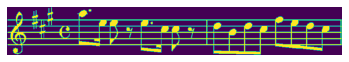

In [56]:
show_img(music_dataset[15])

In [10]:
n_all_det = len(music_dataset)
n_used_det = int(1 * n_all_det)
n_train_det = int(0.8 * n_used_det)
n_test_det = n_used_det - n_train_det
rng_det = torch.Generator().manual_seed(291)
dataset_train, dataset_test, _ = torch.utils.data.random_split(music_dataset, [n_train_det, n_test_det, n_all_det-n_train_det-n_test_det], rng_det)

In [55]:
import torch.nn as nn

# Taken from https://github.com/meijieru/crnn.pytorch

class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        import pdb
        pdb.set_trace()
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [52]:
model_det = CRNN(img_height, 1, music_dataset.vocabulary_size, 256)

torch.nn.init.xavier_uniform_(torch.empty(256,256))
device = torch.device('cuda:0')
model_det.to(device)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [14]:
criterion_det = torch.nn.CTCLoss()
optimizer_det = torch.optim.SGD(model_det.parameters(), lr=0.01)
scheduler_det = torch.optim.lr_scheduler.StepLR(optimizer_det, step_size=5, gamma=0.1)

In [13]:
def concatenate_labels(labels):
    listLabels = []
    for x in labels:
      listLabels.append(x)
    return torch.cat(listLabels, dim=0)

In [54]:
def run_test_det(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test)
    loss = 0
    i = 0 
    preds = []
    model.eval()
    with torch.no_grad():
        while i < nsamples_test:
          dataset = getBatch(dataset_test, i, 16)
          target_lengths = []
          input_lengths = []
          labels = []
          samples = []
          # Here set the target and input lengths for the CTC loss function
          for sample, label in dataset: 
            target_lengths.append(len(label))
            input_lengths.append(sample.shape[2])
            labels.append(label)
            samples.append(sample)
          loader_test = torch.utils.data.DataLoader(samples, batch_size=16, shuffle=False)
          for data in loader_test:
            opt.zero_grad()
            samples = data.to(device)
            outs = model(samples)
            # Set-up the CTC loss function parameters 
            log_probs = torch.randn(input_length[0], 16, music_dataset.vocabulary_size, dtype=torch.float).log_softmax(2)
            loss += criterion(log_probs, labels, input_lengths, target_lengths) * samples.size(0)
            if not no_preds:
                preds += outs.cpu().unbind()
          i += 16
    return loss / nsamples_test, preds

def run_train_det(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar = 0
    i = 0 
    model.train()
    with torch.enable_grad():
        while i < nsamples_train:
          dataset = getBatch(dataset_train, i, 16)
          target_lengths = []
          input_lengths = []
          labels = []
          samples = []
          # Here set the target and input lengths for the CTC loss function
          for sample, label in dataset: 
            target_lengths.append(len(label))
            input_lengths.append(sample.shape[2])
            labels.append(label)
            samples.append(sample)
          loader_train = torch.utils.data.DataLoader(samples, batch_size=16, shuffle=False)
          for data in loader_train:
            opt.zero_grad()
            samples = data.to(device)
            outs = model(samples)
            # Set-up the CTC loss function parameters 
            log_probs = torch.randn(input_length[0], 16, music_dataset.vocabulary_size, dtype=torch.float).log_softmax(2)
            loss = criterion(log_probs, labels, input_lengths, target_lengths)
            #loss.backward()
            #opt.step()
            loss_sofar += loss.item() * samples.size(0)
          i += 16
    sched.step()
    return loss_sofar / nsamples_train

def run_all_det(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train_det(model, criterion, optimizer, scheduler)
        loss_test, _ = run_test_det(model, criterion, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
    return loss_test

In [ ]:
run_all_det(model_det, criterion_det, optimizer_det, scheduler_det, 10)